In [1]:
# !pip isntall -r requirements.txt

In [3]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

import importlib
import config
importlib.reload(config)
# from datasets import load_dataset


<module 'config' from 'c:\\Users\\kuzga\\OneDrive\\Рабочий стол\\ShiftLab-2024-Computer-Vision\\config.py'>

In [4]:
# try:
#     dataset = load_dataset('DonkeySmall/OCR-English-Printed-12', split='train[:1%]')
#     print("Данные загружены успешно!")
# except Exception as e:
#     print(f"Ошибка при загрузке набора данных: {e}")

In [9]:
def cv2_show(img, key='q', time=0, window_name='cv2'):
    print(time)
    cv2.imshow(window_name, img)
    if time:
        cv2.waitKey(time)
        cv2.destroyAllWindows()
    else:
        printed_key = cv2.waitKey(0)
        if printed_key == key:
            cv2.destroyAllWindows()


def stack_images(images, direction='vertical'):
    if not images or any(img is None for img in images):
        raise ValueError(
            "Список изображений пуст или содержит недопустимые значения")

    if direction == 'horizontal':
        min_height = min(img.shape[0] for img in images)
        resized_images = [cv2.resize(img, (int(img.shape[1] * (min_height / img.shape[0])), min_height))
                          for img in images]
        stacked_image = np.hstack(resized_images)
    elif direction == 'vertical':
        min_width = min(img.shape[1] for img in images)
        resized_images = [cv2.resize(img, (min_width, int(img.shape[0] * (min_width / img.shape[1]))))
                          for img in images]
        stacked_image = np.vstack(resized_images)
    else:
        raise ValueError("direction должен быть 'horizontal' или 'vertical'")

    return stacked_image


def add_noise_and_distortion(img):
    noise = np.random.uniform(0, 50, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)

    # искажения с помощью линий
    num_lines = np.random.randint(0, 10)
    for _ in range(num_lines):
        x1, y1 = np.random.randint(
            0, img.shape[1]), np.random.randint(0, img.shape[0])
        x2, y2 = np.random.randint(
            0, img.shape[1]), np.random.randint(0, img.shape[0])
        cv2.line(noisy_img, (x1, y1), (x2, y2), (0, 0, 0), 1)

    return noisy_img


def generate_text_image(text, img=None, noise=False):
    gen_height, gen_width = 64, 256

    if img is None:
        background_color = np.random.randint(0, 256, size=3, dtype=np.uint8)
        img = np.ones((gen_height, gen_width, 3), dtype=np.uint8) * background_color

    # Выбираем случайный шрифт
    font_path = random.choice(config.custom_fonts_paths)
    font_size = random.randint(20, 35)
    font = ImageFont.truetype(font_path, font_size)

    pil_img = Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)

    # Вычисляем размер текста и его позицию
    bbox = draw.textbbox((0, 0), text, font=font)
    text_size = (bbox[2] - bbox[0], bbox[3] - bbox[1])
    while text_size[0] > img.shape[1] or text_size[1] > img.shape[0]:
        font_size -= 1
        font = ImageFont.truetype(font_path, font_size)
        bbox = draw.textbbox((0, 0), text, font=font)
        text_size = (bbox[2] - bbox[0], bbox[3] - bbox[1])

    offset = random.randint(-5, 5)  # Значение смещения от -5 до 5 пикселей
    text_x = (img.shape[1] - text_size[0]) // 2 + offset  # Центрируем текст и добавляем смещение
    text_y = (img.shape[0] - text_size[1]) // 2

    # Цвет текста
    background_color = np.mean(img, axis=(0, 1)).astype(int).tolist()
    text_color = tuple([255 - c for c in background_color])

    for char in text:
        # Получаем размер текущей буквы
        bbox = draw.textbbox((text_x, text_y), char, font=font)
        char_width = bbox[2] - bbox[0]
        char_height = bbox[3] - bbox[1]
        x_offset = random.randint(round(char_width * (-0.01)), round(char_width * (0.01)) // 1)
        y_offset = random.randint(round(char_height * (-0.1)) // 1, round(char_height * (0.1)) // 1)
        draw.text((text_x + x_offset, text_y + y_offset), char, font=font, fill=text_color)

        # Увеличиваем x для следующей буквы
        text_x += char_width  # Сдвигаем на ширину текущей буквы

    # Преобразуем обратно в формат OpenCV
    img = np.array(pil_img)

    # Добавляем шум и искажения, если требуется
    if noise:
        return add_noise_and_distortion(img)
    return img

In [10]:
images = []

for _ in range(10):
    text = random.choice(config.texts)
    image = generate_text_image(text, noise=False)
    images.append(image)

stacked_images = stack_images(images)
cv2_show(stacked_images, time=10000)
# cv2_show(stacked_images)

10000


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

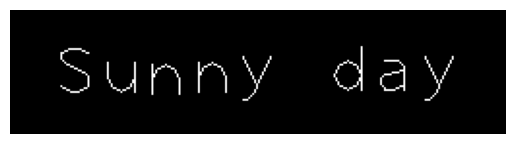

In [7]:
from torchvision import transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor()
])


class TextImageDataset(Dataset):
    def __init__(self, texts, transform=None):
        self.texts = texts
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        img = generate_text_image(text)
        # img = add_noise_and_distortion(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Переводим в ч/б
        img = img / 255.0  # Нормализуем

        img = Image.fromarray((img * 255).astype('uint8'))
        if self.transform:
            img = self.transform(img)

        return img, text


dataset = TextImageDataset(config.texts, transform=transform)
img, _ = dataset[0]
plt.imshow(img.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

In [12]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, (4, 16), 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.fc = nn.Linear(ndf * 8 * 4 * 16, 1)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [15]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 50
lr = 0.0002
beta1 = 0.5

batch_size = 16
nz = 100
ngf = 16
ndf = 16
nc = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

generator = Generator(nz, ngf, nc).to(device)
discriminator = Discriminator(nc, ndf).to(device)

optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

D_losses = []
G_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        discriminator.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)

        output = discriminator(real_images).view(-1)
        loss_real = criterion(output, labels)
        loss_real.backward()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = generator(noise)
        labels.fill_(0.0)

        output = discriminator(fake_images.detach()).view(-1)
        loss_fake = criterion(output, labels)
        loss_fake.backward()

        D_loss = loss_real + loss_fake
        optimizerD.step()

        generator.zero_grad()
        labels.fill_(1.0)
        output = discriminator(fake_images).view(-1)
        G_loss = criterion(output, labels)
        G_loss.backward()
        optimizerG.step()

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Step [{i}/{len(dataloader)}] | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
        plt.axis('off')
        plt.show()

torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x2048 and 8192x1)